In [1]:
import mlplol
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

We will use the diabetes regression dataset from sklearn

In [2]:
diabetes = sklearn.datasets.load_diabetes()

def split_data_np(features, target, validation_fraction, test_fraction):
    N = features.shape[0]
    inds_shuffled = np.random.permutation(np.arange(0, N))
    train_thresh = int(np.round(inds_shuffled.shape[0] * (1 - test_fraction - validation_fraction)))
    val_thresh = int(np.round(inds_shuffled.shape[0] * (1 - test_fraction)))
    train_inds = inds_shuffled[0:train_thresh]
    val_inds = inds_shuffled[train_thresh:val_thresh]
    test_inds = inds_shuffled[val_thresh:]

    trainX = features[train_inds, :]
    trainY = target[train_inds]

    valX = features[val_inds, :]
    valY = target[val_inds]

    testX = features[test_inds, :]
    testY = target[test_inds]

    return dict(trainx=trainX, trainy=trainY, valx=valX, valy=valY, testx=testX, testy=testY)


diabetes_split = split_data_np(diabetes.data, diabetes.target, 0.2, 0.2)

In [4]:
# check the shape
diabetes_split['trainx'].shape

(265, 10)

We verify that the gradient is correct.

In [5]:
# make some test weights
wtest1 = np.random.normal(0, 1, (diabetes.data.shape[1]+1, 10))
wtest2 = np.random.normal(0, 1, (11, 1))

test_gradients = mlplol.gradient_quotients([wtest1, wtest2], diabetes_split['trainx'],
                diabetes_split['trainy']) # should be arrays of ones

In [6]:
print([i for i in test_gradients])

[array([[1.        , 1.        , 1.        , 1.00000015, 1.00000012,
        1.00000041, 1.        , 0.99998768, 1.0000007 , 0.9999998 ],
       [1.        , 1.        , 1.        , 0.99998485, 0.99991047,
        1.00009119, 1.        , 1.00006589, 1.00005716, 0.99993642],
       [1.        , 1.        , 1.        , 1.00031376, 1.00930703,
        0.99915672, 1.        , 1.00017119, 1.00124835, 1.00308931],
       [1.        , 1.        , 1.        , 0.99999458, 1.00000711,
        1.00000385, 1.        , 0.99997413, 1.00001054, 0.99997813],
       [1.        , 1.        , 1.        , 1.00000418, 0.99998928,
        1.00003516, 1.        , 0.99989336, 1.00000733, 0.99999411],
       [1.        , 1.        , 1.        , 1.00009434, 0.99995241,
        0.99994283, 1.        , 1.00016832, 0.99999195, 0.99998913],
       [1.        , 1.        , 1.        , 1.00005445, 1.00002359,
        0.99993866, 1.        , 1.00046886, 0.99999554, 1.00002206],
       [1.        , 1.        , 1.      

We train a model.

In [8]:
diabetes_nn = mlp_sinc = mlplol.NNregressor_onelayer(activation_function = 'relu')
diabetes_nn.estimate_weights(diabetes_split['trainx'], diabetes_split['trainy'], diabetes_split['valx'],
                             diabetes_split['valy'], n_hidden=100,
                              iterations=100, patience=10, rate=0.001,
                              verbose=False, weight_initialization_factors=None)

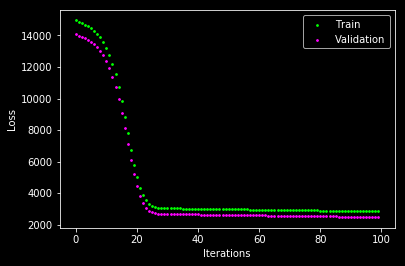

In [9]:
plt.style.use("dark_background")
plt.scatter(np.arange(diabetes_nn.iterations), diabetes_nn.training_loss, s=3, c='lime', label='Train')
plt.scatter(np.arange(diabetes_nn.iterations), diabetes_nn.validation_loss, s=3, c='fuchsia', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.show()